In [1]:
import numpy as np
import json
import pickle

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)

from IPython.display import clear_output

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator

In [4]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

In [5]:
from sklearn.model_selection import train_test_split

**1) Circuit Components**

In [6]:
feature_map = ZFeatureMap(4) # the first step of QNN : loading data : ZFeatureMap or ZZFeatureMap

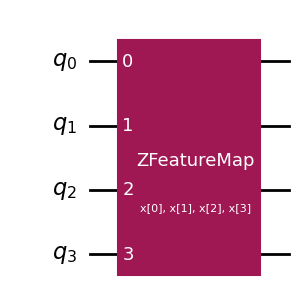

In [7]:
feature_map.draw('mpl')

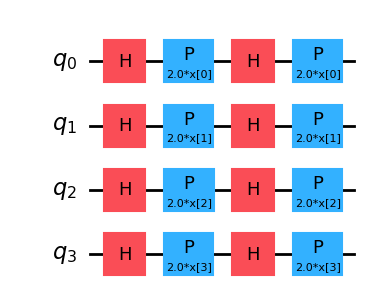

In [8]:
feature_map.decompose().draw('mpl')

**1.2. Convoltional Layer**

In [143]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi/2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi/2, 0)
    return target

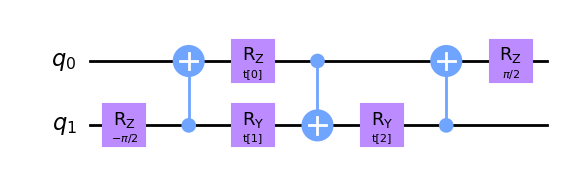

In [157]:
params = ParameterVector("t", length=3) # ParameterVector is a Qiskit class used to create multiple parameters at once.
circuit = conv_circuit(params)
circuit.draw('mpl', style="clifford") # style : default, clifford, iqx, pale, bw, text

In [145]:
# params

In [146]:
def conv_layer(num_qubit, param_name):
    qc = QuantumCircuit(num_qubit, name="Conv. Layer")
    qubits = list(range(num_qubit)) # list all the qubits from 0 to 7 in one vector : [0, 1, 2, 3, 4, 5, 6, 7]
    #qubits
    params = ParameterVector(param_name, length=num_qubit*3)
    param_index = 0
    
    for q1, q2 in zip(qubits[0::2], qubits[1::2]): # from 0 with step 2 : [0, 2, 4, 6], zip can give multi iterators but they have to have at the smae length necesserily
        # element by element
        qc = qc.compose(conv_circuit(params[param_index:param_index+3]), [q1, q2]) # [param_index:param_index+3] : a slice of three parameters
        param_index += 3 # increase the index by 3 for the next pair of qubits.
        qc.barrier()
        
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index:param_index+3]), [q1, q2])
        param_index += 3
        qc.barrier()

    qc_inst = qc.to_instruction() #pack the circuit, convert a QuantumCircuit object into a single gate-like instruction that can be inserted into another circuit
    circuit = QuantumCircuit(num_qubit, name="Conv. Layer")
    circuit.append(qc_inst, qubits)
    return circuit

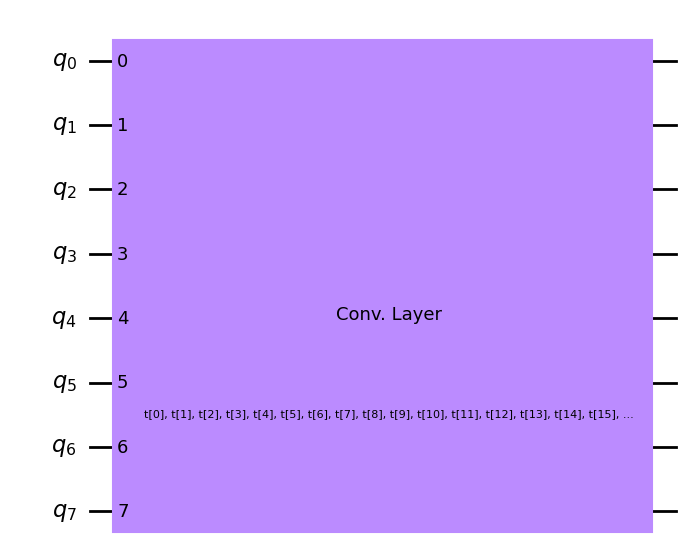

In [156]:
circuit = conv_layer(8, "t")
circuit.draw('mpl', fold=400, style="clifford")

**1.3. Pooling Layer**

In [148]:
def pooling_circuit(params2):
    target = QuantumCircuit(2)
    target.rz(-np.pi/2, 1)
    target.cx(1, 0)
    target.rz(params2[0], 0)
    target.ry(params2[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target

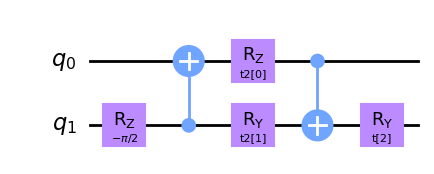

In [155]:
params2 = ParameterVector("t2", length=3)
circuit = pooling_circuit(params2)
circuit.draw('mpl', style="clifford")

In [150]:
def pooling_layer(num_qubit2, param_name2):
    qc = QuantumCircuit(num_qubit2, name="Pooling Layer")
    qubits = list(range(num_qubit2))
    qubits_half = qubits[:num_qubit2//2] # first half
    qubits_other_half = qubits[num_qubit2//2:]  # second half
    params2 = ParameterVector(param_name2, length=num_qubit2 * 3)
    param_index = 0
    for q1, q2 in zip(qubits_half, qubits_other_half):
        qc = qc.compose(pooling_circuit(params2[param_index:param_index+3]), [q1, q2])
        param_index += 3
        qc.barrier()

    qc_inst = qc.to_instruction()
    circuit2 = QuantumCircuit(num_qubit2, name="Pooling Layer")
    circuit2.append(qc_inst, qubits)
    return circuit2


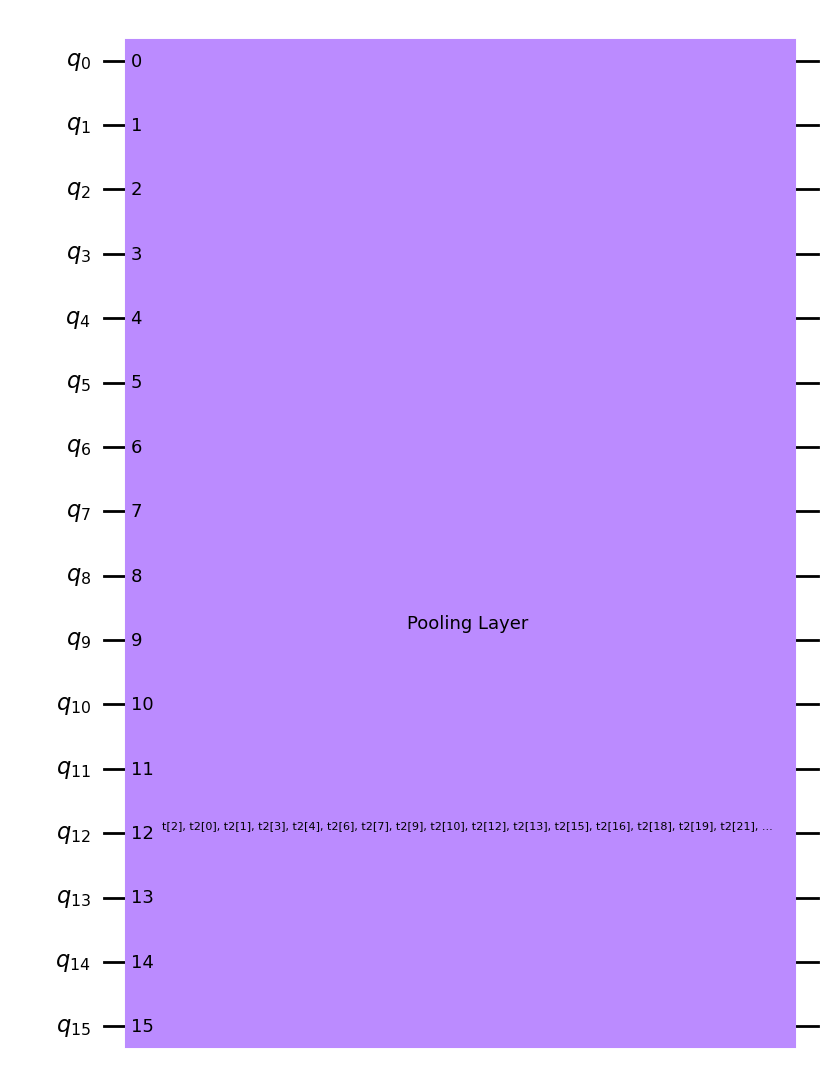

In [154]:
circuit2 = pooling_layer(16, "t2")
circuit2.draw('mpl', style="clifford", fold=200)

In [152]:
feature_map = ZFeatureMap(8)

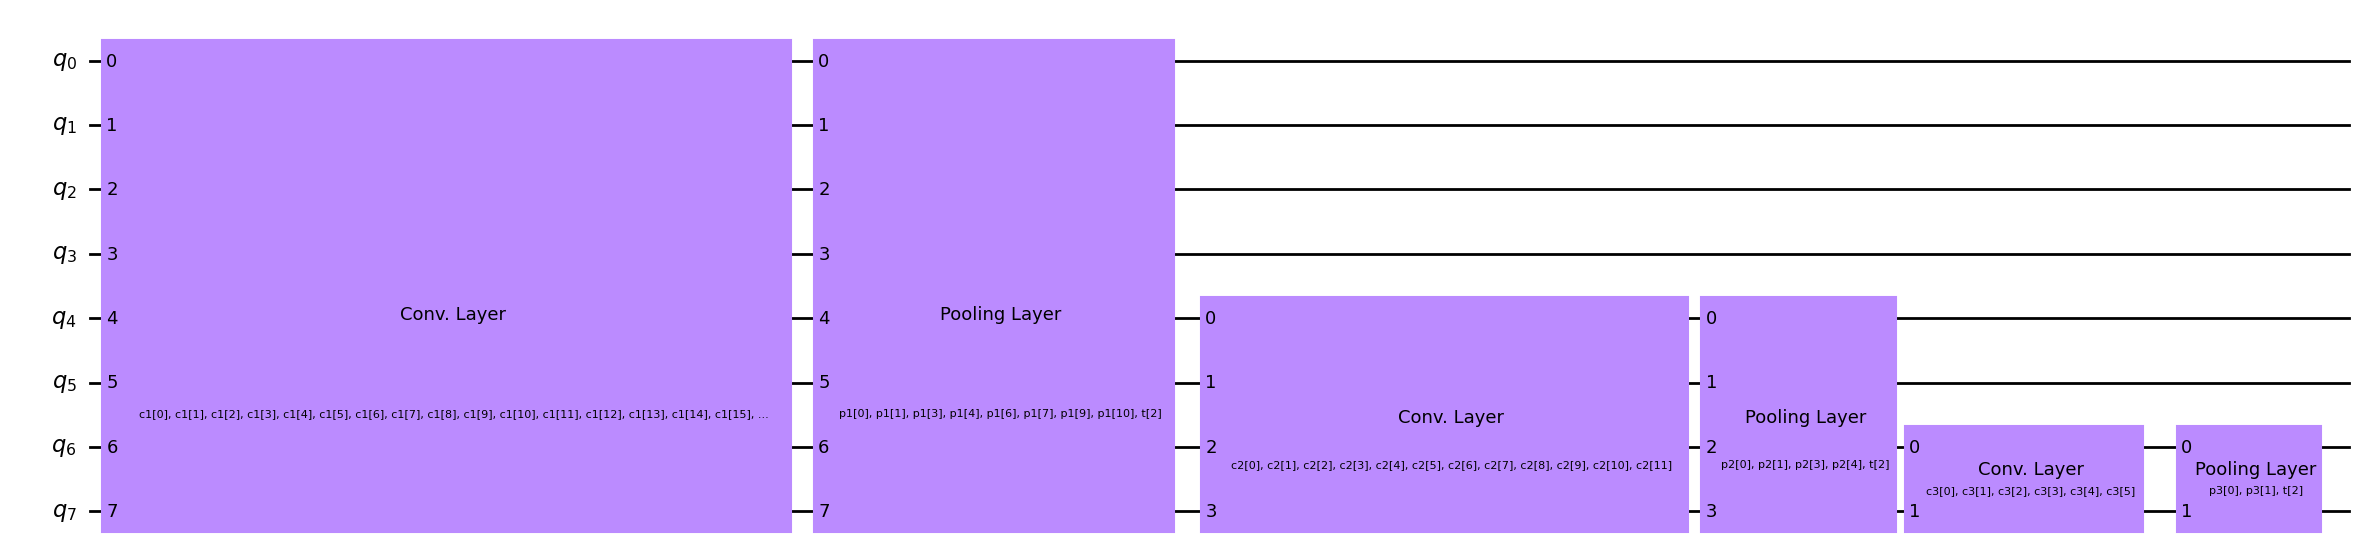

In [211]:
ansatz = QuantumCircuit(8, name="Ansats")

num_qubit2 = num_qubit
num_qubit3 = 8
#n = len(num_qubit3)

qubits_other_half1 = qubits[num_qubit3//2:]  # second half
n=len(qubits_other_half1)
n_int_float = int(num_qubit3 - n/2)
qubits_other_half2 = qubits[:n//2]  # second half
qubits_other_half2


ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)
ansatz.compose(pooling_layer(8, "p1"), list(range(8)), inplace=True)
ansatz.compose(conv_layer(4, "c2"), qubits_other_half1, inplace=True)
ansatz.compose(pooling_layer(4, "p2"), qubits_other_half1, inplace=True)
ansatz.compose(conv_layer(2, "c3"), [n_int_float, num_qubit3-1], inplace=True)
ansatz.compose(pooling_layer(2, "p3"), [n_int_float, num_qubit3-1], inplace=True)

ansatz.draw('mpl', style="clifford", fold=200)

In [212]:
#for i in range(num_qubit3):
#    conv_name = f"c{i}"   
#    pool_name = f"p{i}"
#    ansatz.compose(conv_layer(num_qubit3, conv_name), list(range(num_qubit3)), inplace=True)
#    ansatz.compose(pooling_layer(num_qubit3, pool_name), list(range(num_qubit3)), inplace=True)

In [213]:
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

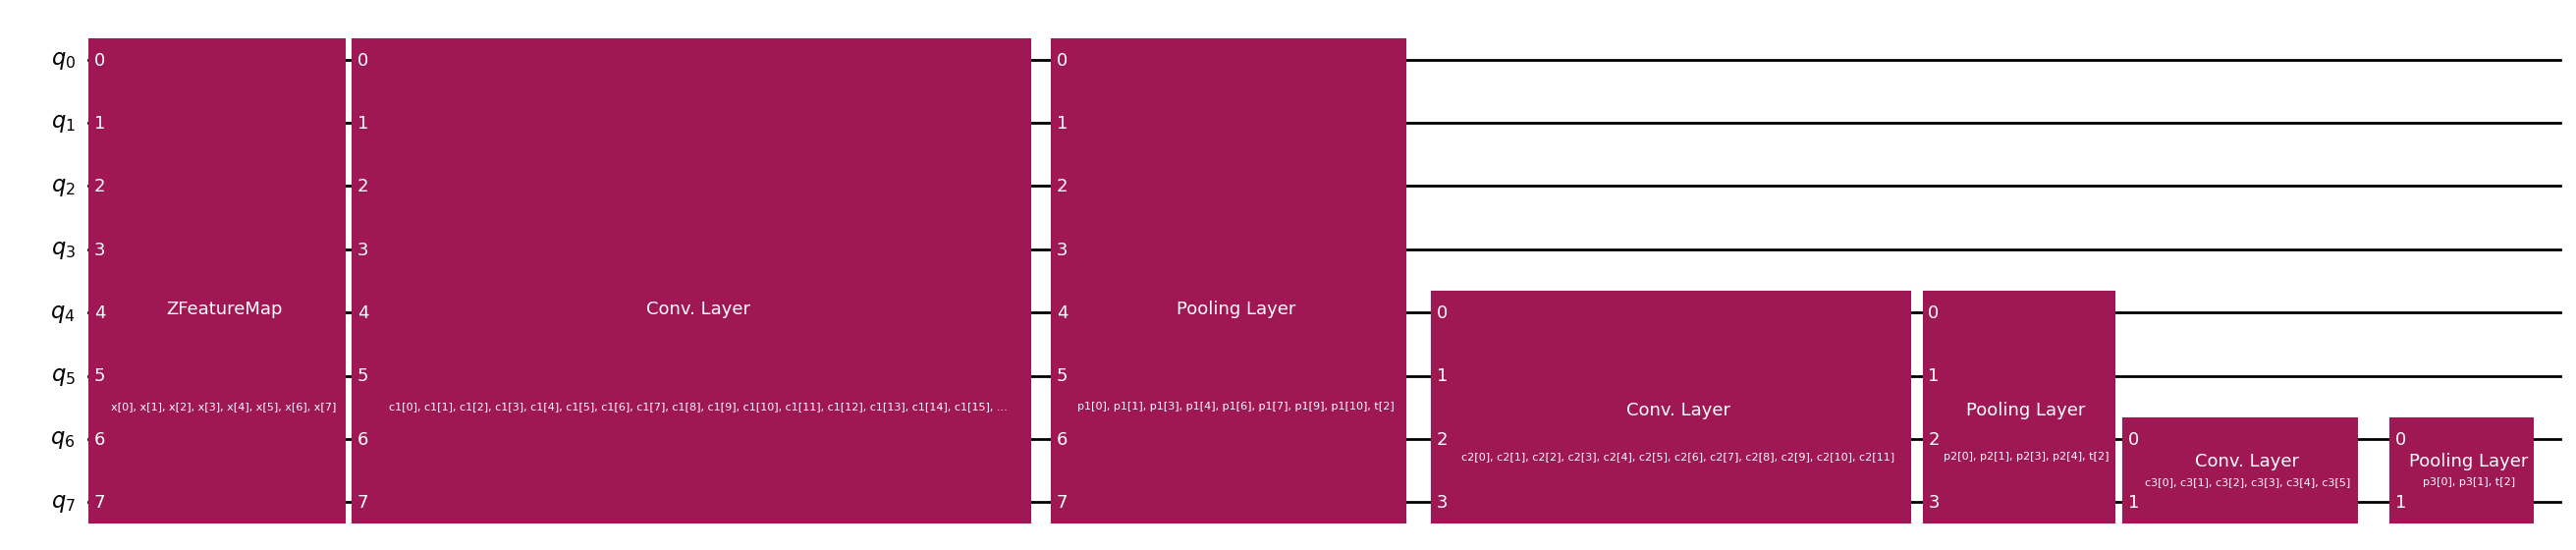

In [215]:
circuit.draw('mpl', fold=200)

In [216]:
observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)]) # (Hamiltonian, weight)

In [217]:
estimator = Estimator()

In [218]:
qnn = EstimatorQNN(
                   circuit       = circuit.decompose(),
                   observables   = observable,
                   input_params  = feature_map.parameters,
                   weight_params = ansatz.parameters,
                   estimator     = estimator
                  )

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [207]:
feature_map.parameters # parametervector which had been defined and they are not trainable, they would give amount after we get it input data

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7])])

In [208]:
ansatz.parameters

ParameterView([ParameterVectorElement(c0[0]), ParameterVectorElement(c0[1]), ParameterVectorElement(c0[2]), ParameterVectorElement(c0[3]), ParameterVectorElement(c0[4]), ParameterVectorElement(c0[5]), ParameterVectorElement(c0[6]), ParameterVectorElement(c0[7]), ParameterVectorElement(c0[8]), ParameterVectorElement(c0[9]), ParameterVectorElement(c0[10]), ParameterVectorElement(c0[11]), ParameterVectorElement(c0[12]), ParameterVectorElement(c0[13]), ParameterVectorElement(c0[14]), ParameterVectorElement(c0[15]), ParameterVectorElement(c0[16]), ParameterVectorElement(c0[17]), ParameterVectorElement(c0[18]), ParameterVectorElement(c0[19]), ParameterVectorElement(c0[20]), ParameterVectorElement(c0[21]), ParameterVectorElement(c0[22]), ParameterVectorElement(c0[23]), ParameterVectorElement(c1[0]), ParameterVectorElement(c1[1]), ParameterVectorElement(c1[2]), ParameterVectorElement(c1[3]), ParameterVectorElement(c1[4]), ParameterVectorElement(c1[5]), ParameterVectorElement(c1[6]), ParameterV

**5. Train**

**5.1. Load Data**

In [265]:
def load_dataset(pickle_file=r"D:\university\quantum\Qiskit\codes\dataset.pkl"):
    with open(pickle_file, 'rb') as f: # 'rb' means Read Binary, "with" ensures the file is automatically closed after reading
#       Memory leak – the file handle stays open in memory.
#       File locking – on some systems, the file might be locked, so other programs or even your code can’t access it.
#       Data corruption – especially if writing to a file; changes may not be fully saved until closed
#       f is the file object used to read the data.
        images, labels = pickle.load(f) # Reads Python objects stored in the file f using pickle
#       Expects the pickle file to contain two objects: images and labels.
#       Assigns them to the variables images and labels.
    return images, labels

images, labels = load_dataset()
#The ones inside disappear when the function ends.
#The ones outside are your “copies” of the returned data.

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=246)
#because it pricesses tth dataset shufflely so we put a constant random_state to save one random_state because of measuring aqquracy
#random_state=246 → ensures the split is reproducible. Using the same number always produces the same split

**5.2. Trainer**

In [266]:
# for access to intermediate results during training
#that’s a callback function for tracking and visualizing optimization progress
objective_func_vals = [] #this creates an empty list to store the values of the objective function
def callback_graph(weight, obj_func_eval): # obj_func_eval : the current objective function value
    clear_output(wait=True) # This clears the previous output in the notebook (so it doesn’t print multiple plots over each other).
#   It makes the plot update “live” instead of stacking up
#   weight=True : Wait to clear the output until something new is ready to display
    objective_func_vals.append(obj_func_eval) # This saves the latest objective value in your list so you can track all iterations.
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
#   makes a sequence of numbers from 0 up to (but not including) that number.
#   For example, if there are 5 values, it gives [0, 1, 2, 3, 4].
#   So this is your x-axis: iteration numbers.
    plt.show()

In [267]:
classifier = NeuralNetworkClassifier( # wraps a Quantum Neural Network (QNN) into a machine learning classifier. It trains your QNN to classify data
    qnn,
    optimizer = COBYLA(maxiter=200), # it will stop after 200 iterations.
    callback = callback_graph, # we did not call the function : callback_graph() to start reading the function just name that
#   Call this function every time you finish one iteration.
)

**5.3. Train**

**5.3.1. Train Trust**

In [268]:
x_train = np.asarray(train_images)
y_train = np.asarray(train_labels)
# np is the short name for NumPy, the numerical computing library.
# asarray() is a NumPy function that converts data (like a list, tuple, or other structure) into a NumPy array.
# at all : Take the variable train_images and convert it into a NumPy array, then store it in x_train

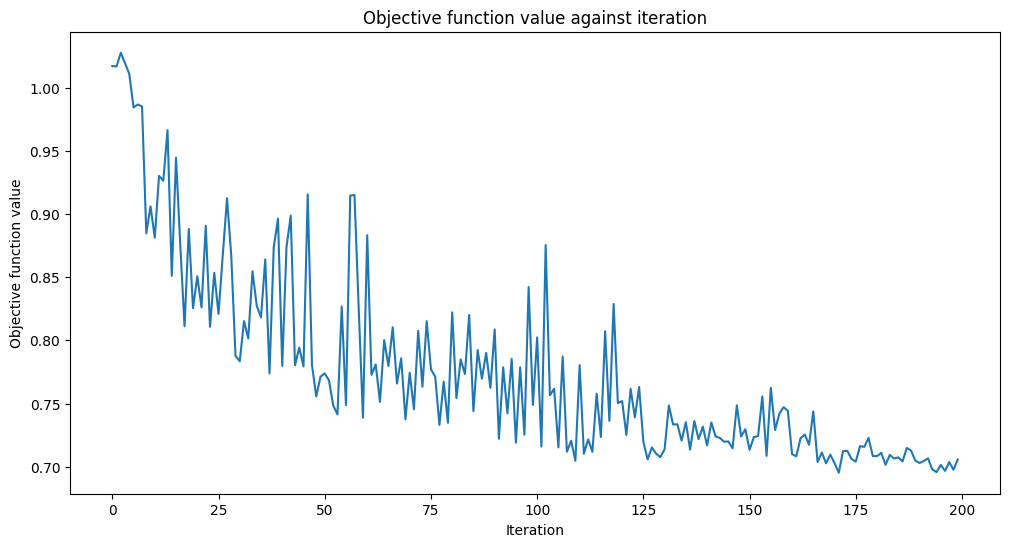

In [269]:
classifier.fit(x_train, y_train) # .fit : Start learning from the training data.

**5.3.2. Train Results**

In [270]:
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x_train, y_train), 2)}%")
# f" : It lets you mix text and Python expressions easily.
# Anything inside { } is evaluated and inserted into the text.
# .score : It tests the trained model using x_train and y_train. It returns the accuracy, meaning the fraction of samples predicted correctly.
# np.round() (from NumPy) rounds numbers to a chosen number of decimal places.
# 2 means you want two digits after the decimal point.

Accuracy from the train data : 100.0%


**6. Test Model**

In [271]:
x_test = np.asarray(test_images)
y_test = np.asarray(test_labels)

In [272]:
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x_test, y_test), 2)}%")

Accuracy from the test data : 100.0%


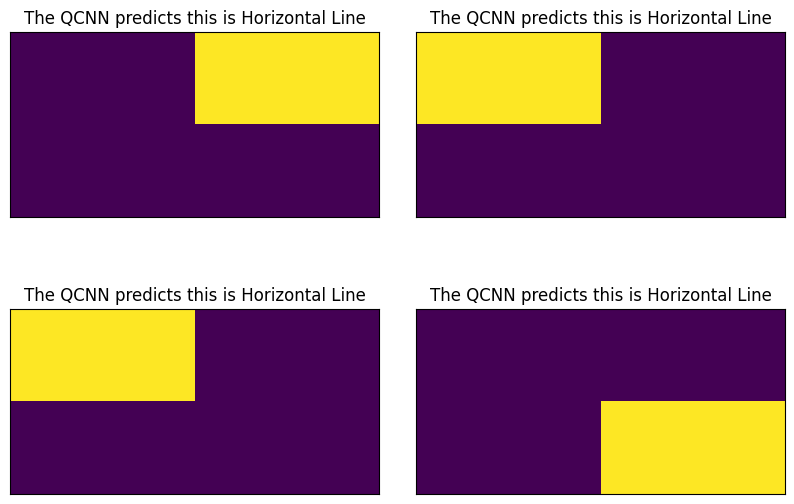

In [273]:
y_predict = classifier.predict(test_images) # Calls the predict method of your trained model (classifier).
# Returns the predicted labels (e.g., -1 or +1) and stores them in y_predict.
# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
# Creates a 2×2 grid of subplots (so 4 plots total).
# figsize=(10, 6) controls the figure size in inches.
# subplot_kw={'xticks': [], 'yticks': []} removes the x and y tick marks (for cleaner plots).
# fig is the whole figure, ax is a 2D array of axes (the small plots).
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 4), aspect="equal")
#   imshow() shows an image in that subplot.
#   .reshape(2, 4) reshapes the data (for example, if it was stored as a 1D array of 8 pixels, it becomes 2×4 for display).
#   aspect='equal' ensures pixels are square.
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("the QCNN predicts this is a Vertical line")
plt.subplots_adjust(wspace=0.1, hspace=0.5) # Adjusts the spacing between subplots.


# () means function call, but here you’re accessing an array element. Use square brackets [] for indexing.
# In Python, keyword dictionaries must use {} not (). parentheses makes it a tuple, not a dictionary.
# in classical ML wwe use 0, 1 But in quantum ML, measurement results are often expectations of Pauli-Z operators, which return values in {+1, -1}.